# Land Type Classification using Sentinel-2 Satellite Images

#### This project focuses on leveraging Deep Neural Networks (DNNs) to classify different land types (such as agriculture, water, urban areas, desert, roads, and trees).

## Step 1: Data Collection:

#### EuroSAT is a well-known dataset of Sentinel-2 satellite images designed for land use and land cover classification.
Download dataset [EuroSAT Dataset (RGB)](https://madm.dfki.de/files/sentinel/EuroSAT.zip)

#### Path to the dataset: 'EuroSAT/2750/' with 10 subfolders each containing around 2000-3000 images.

## Step 2: Data Exploration:

In [85]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import cv2
from collections import Counter

In [86]:
# Define dataset path
dataset_path = "EuroSAT/2750/"

In [87]:
# List all land type categories
categories = os.listdir(dataset_path)

## Step 3: Data Preprocessing:

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [70]:
# Resize, normalize, and convert to RGB
def load_and_preprocess_images(path, size=(64, 64)):
    data, labels = [], []
    for category in categories:
        category_path = os.path.join(path, category)
        for img_name in os.listdir(category_path):
            img = cv2.imread(os.path.join(category_path, img_name))
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = img / 255.0  # Normalize to [0,1]
            data.append(img)
            labels.append(category)
    return np.array(data, dtype="float32"), np.array(labels)

In [71]:
# Load data
data, labels = load_and_preprocess_images(dataset_path)

In [72]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [73]:
# Encode labels into integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # Convert category names to integer labels

In [74]:
# Convert to one-hot encoding
labels_categorical = to_categorical(labels_encoded)

In [75]:
# Split dataset into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [76]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
)

# datagen = ImageDataGenerator(
#     rotation_range=25,    # Slightly increased, but not too much
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     shear_range=0.1  # Just a little shear (not too aggressive)
# )

In [77]:
val_test_datagen = ImageDataGenerator()  # No rescale!

# Final datasets
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

#### Visualizing Augmented Images
Since we've applied transformations, it's essential to visualize the modified images to ensure they're applied correctly.

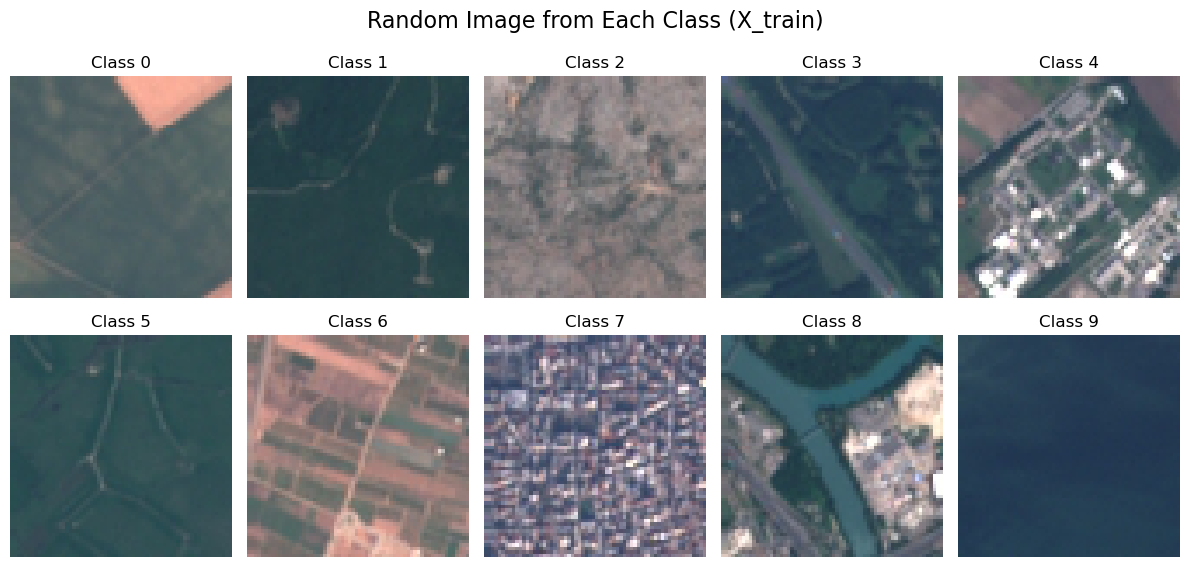

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get the unique class indices
num_classes = y_train.shape[1]  # Number of classes
class_indices = np.argmax(y_train, axis=1)  # Convert one-hot to class labels

# Create a figure for visualization
plt.figure(figsize=(12, 6))

for class_id in range(num_classes):
    # Get all indices of images belonging to this class
    indices = np.where(class_indices == class_id)[0]
    
    # Pick a random index
    random_idx = random.choice(indices)
    
    # Get the image
    img = X_train[random_idx]
    
    # Plot the image
    plt.subplot(2, (num_classes + 1) // 2, class_id + 1)
    plt.imshow(img)
    plt.title(f"Class {class_id}")
    plt.axis('off')

plt.suptitle("Random Image from Each Class (X_train)", fontsize=16)
plt.tight_layout()
plt.show()


#### Class Distribution Visualization (After Preprocessing)

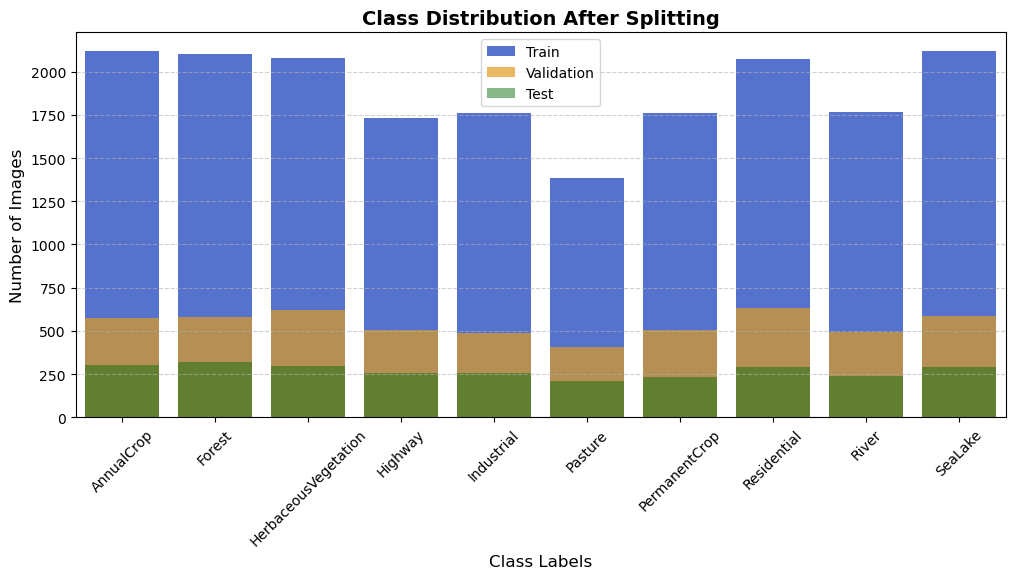

In [17]:
# Convert one-hot encoded labels to class indices
train_labels = np.argmax(y_train, axis=1)
val_labels = np.argmax(y_val, axis=1)
test_labels = np.argmax(y_test, axis=1)

# Count the number of occurrences per class
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

# Get class names
class_names = label_encoder.classes_  # Assuming label_encoder was used for encoding

# Convert data to list format for seaborn
class_labels = list(class_names)
train_values = [train_counts[i] for i in range(len(class_names))]
val_values = [val_counts[i] for i in range(len(class_names))]
test_values = [test_counts[i] for i in range(len(class_names))]

# Plot class distribution for train, val, and test
plt.figure(figsize=(12, 5))
sns.barplot(x=class_labels, y=train_values, color="royalblue", label="Train")
sns.barplot(x=class_labels, y=val_values, color="orange", label="Validation", alpha=0.7)
sns.barplot(x=class_labels, y=test_values, color="green", label="Test", alpha=0.5)

# Add labels & title
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution After Splitting", fontsize=14, fontweight="bold")

plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better visibility
plt.yticks(fontsize=10)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

In [18]:
# Check total samples
print(f"Total Data: {len(data)}")
print(f"Train Set: {len(X_train)}")
print(f"Validation Set: {len(X_val)}")
print(f"Test Set: {len(X_test)}")

Total Data: 27000
Train Set: 18900
Validation Set: 5400
Test Set: 2700


## PCA & t-SNE for Feature Visualization
Dimensionality reduction techniques like t-SNE or PCA can visualize image clusters.

#### Benefits of Using PCA & t-SNE in EDA
- **Feature Understanding**:
  - Helps inspect how well the dataset is structured.
  - Identifies similarities and differences between images.
- **Class Distribution & Clustering**:
  - Shows whether different classes form distinct clusters.
  - Detects overlapping or misclassified classes.
- **Detecting Anomalies**:
  - Helps spot outliers in the dataset.
  - Unusual points may indicate data quality issues.
- **Model Selection Insight**:
  - If classes are well-separated, a simple classifier like Logistic Regression might work.
  - If classes overlap, a deep learning model may be needed.

In [14]:
# Create DataLoaders
# DataLoaders help in loading batches efficiently during training:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [23]:
# Function to extract image features from the dataset
def extract_features(dataloader):
    features = []
    labels = []
    
    for images, lbls in dataloader:
        images = images.view(images.size(0), -1)  # Flatten images
        features.append(images.numpy())
        labels.extend(lbls.numpy())
    
    return np.vstack(features), np.array(labels)

In [24]:
# Extract features from training set
features, labels = extract_features(train_loader)

In [25]:
# Apply PCA (reduce to 2 components for visualization)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

In [26]:
# Apply t-SNE (reduce to 2 components for visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(features)

Text(0, 0.5, 'Principal Component 2')

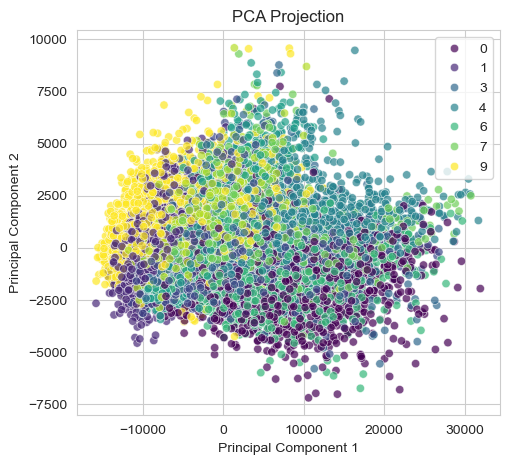

In [27]:
# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Text(0, 0.5, 't-SNE Component 2')

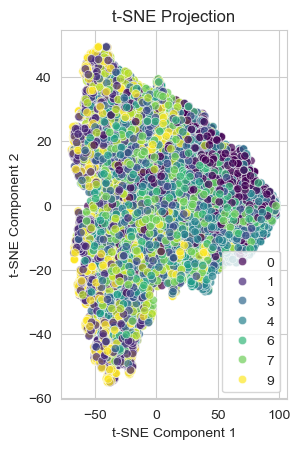

In [28]:
# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Projection")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

#### Conclusion:
- High overlap in PCA & t-SNE means the dataset does not have well-separated clusters **(not linearly separable)**.
  - This suggests that images from different classes look somewhat similar in feature space.
  - Simple classifiers like logistic regression or linear SVM may struggle.
- t-SNE improves local clustering slightly, but classes are still mixed.
  - This tells us that even with a non-linear method, the data does not have naturally distinct groups.

#### We might need better feature extraction (e.g., CNN embeddings) to extract better features before classification to classify the data well.